In [4]:
!pip install pyspark #installing Pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# creating a spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

#Data Cleanising
##### Importing the data.

In [8]:
 %%time
#logging the time taken
#File location and type
path = '/content/Global-Superstore.csv'
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# Import csv. The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(path)

df.head() #first row object

CPU times: user 15.3 ms, sys: 4.14 ms, total: 19.4 ms
Wall time: 2.08 s


Row(Index=1, Row ID=32298, Order ID='CA-2012-124891', Order Date='7/31/2012', Ship Date='7/31/2012', Ship Mode='Same Day', Customer ID='RH-19495', Customer Name='Rick Hansen', Segment='Consumer', City='New York City', State='New York', Country='United States', Postal Code=10024, Market='US', Region='East', Product ID='TEC-AC-10003033', Category='Technology', Sub-Category='Accessories', Product Name='Plantronics CS510 - Over-the-Head monaural Wireless Headset System', Sales='2309.65', Quantity='7', Discount='0', Profit=762.1845, Shipping Cost=933.57, Order Priority='Critical')

In [10]:
df.show()

+-----+------+---------------+----------+----------+--------------+-----------+----------------+-----------+-------------+---------------+-------------+-----------+------+------------+----------------+---------------+------------+--------------------+--------+--------+--------+----------+-------------+--------------+
|Index|Row ID|       Order ID|Order Date| Ship Date|     Ship Mode|Customer ID|   Customer Name|    Segment|         City|          State|      Country|Postal Code|Market|      Region|      Product ID|       Category|Sub-Category|        Product Name|   Sales|Quantity|Discount|    Profit|Shipping Cost|Order Priority|
+-----+------+---------------+----------+----------+--------------+-----------+----------------+-----------+-------------+---------------+-------------+-----------+------+------------+----------------+---------------+------------+--------------------+--------+--------+--------+----------+-------------+--------------+
|    1| 32298| CA-2012-124891| 7/31/2012| 7

# Step1: Removing irrelevant data

In [27]:
df.createOrReplaceTempView("custseg")

In [13]:
sqlDF = spark.sql("SELECT * FROM custseg limit 10;")
sqlDF.show()

+-----+------+---------------+----------+----------+--------------+-----------+----------------+-----------+-------------+---------------+-------------+-----------+------+-------+----------------+---------------+------------+--------------------+--------+--------+--------+----------+-------------+--------------+
|Index|Row ID|       Order ID|Order Date| Ship Date|     Ship Mode|Customer ID|   Customer Name|    Segment|         City|          State|      Country|Postal Code|Market| Region|      Product ID|       Category|Sub-Category|        Product Name|   Sales|Quantity|Discount|    Profit|Shipping Cost|Order Priority|
+-----+------+---------------+----------+----------+--------------+-----------+----------------+-----------+-------------+---------------+-------------+-----------+------+-------+----------------+---------------+------------+--------------------+--------+--------+--------+----------+-------------+--------------+
|    1| 32298| CA-2012-124891| 7/31/2012| 7/31/2012|      

In [20]:
columns_to_drop = ['Row Id', 'Order Priority','Shipping Cost','Market','Segment']
df = df.drop(*columns_to_drop)

### After Cleaning Data

In [26]:
df.show()
df.createOrReplaceTempView("custseg")

+-----+---------------+----------+----------+--------------+-----------+----------------+-------------+---------------+-------------+-----------+------------+----------------+---------------+------------+--------------------+--------+--------+--------+----------+
|Index|       Order ID|Order Date| Ship Date|     Ship Mode|Customer ID|   Customer Name|         City|          State|      Country|Postal Code|      Region|      Product ID|       Category|Sub-Category|        Product Name|   Sales|Quantity|Discount|    Profit|
+-----+---------------+----------+----------+--------------+-----------+----------------+-------------+---------------+-------------+-----------+------------+----------------+---------------+------------+--------------------+--------+--------+--------+----------+
|    1| CA-2012-124891| 7/31/2012| 7/31/2012|      Same Day|   RH-19495|     Rick Hansen|New York City|       New York|United States|      10024|        East| TEC-AC-10003033|     Technology| Accessories|Plan

In [24]:
sqlDF = spark.sql("SELECT * FROM custseg limit 10;")
sqlDF.show()

+-----+---------------+----------+----------+--------------+-----------+----------------+-------------+---------------+-------------+-----------+-------+----------------+---------------+------------+--------------------+--------+--------+--------+----------+
|Index|       Order ID|Order Date| Ship Date|     Ship Mode|Customer ID|   Customer Name|         City|          State|      Country|Postal Code| Region|      Product ID|       Category|Sub-Category|        Product Name|   Sales|Quantity|Discount|    Profit|
+-----+---------------+----------+----------+--------------+-----------+----------------+-------------+---------------+-------------+-----------+-------+----------------+---------------+------------+--------------------+--------+--------+--------+----------+
|    1| CA-2012-124891| 7/31/2012| 7/31/2012|      Same Day|   RH-19495|     Rick Hansen|New York City|       New York|United States|      10024|   East| TEC-AC-10003033|     Technology| Accessories|Plantronics CS510...| 23

### Step 2 and Step3
2. Delete formating
Some of the columns heading were aligned centrally, so have used excel's built-in function 
i.e. clear format option to manage the text being aligned in order to maintain consistency of alignment among all column fields.


3. Data Parsing from Text to Column
Sometimes, there is a possibility that one cell might have multiple data elements separated by a data delimiter like a space, comma, semi-colon.
In our data set, we have one column that have customer full name. This customer name column stores the full name. 
We have divided this into first name, last name from the name column into separate columns. 
Excel's inbuilt functionality called "text to column" can achieve this. 
After using that functionality we have the first name and the last name name separated by space as the data delimiter. This can be visible in our dataset.

#Step4: Removed empty fields
Used excel's filter option and removed rows which are empty


#*Step5* : Fixed date column issue
Applied Date format for the date columns. In our dataset, changed General format to Date format for Order Date and Ship Date fields

In [25]:
df.na.drop().show(truncate=False)

+-----+--------------+----------+----------+--------------+-----------+--------------------+----------------+--------------+-------------+-----------+-------+---------------+---------------+------------+---------------------------------------------------------------------------+--------+--------+--------+----------+
|Index|Order ID      |Order Date|Ship Date |Ship Mode     |Customer ID|Customer Name       |City            |State         |Country      |Postal Code|Region |Product ID     |Category       |Sub-Category|Product Name                                                               |Sales   |Quantity|Discount|Profit    |
+-----+--------------+----------+----------+--------------+-----------+--------------------+----------------+--------------+-------------+-----------+-------+---------------+---------------+------------+---------------------------------------------------------------------------+--------+--------+--------+----------+
|1    |CA-2012-124891|7/31/2012 |7/31/2012 |Sa

# Exporting the data for Power BI

In [ ]:
# Write spark DataFrame data to CSV file
df.write.csv("CustSegmentaion.csv")

# Validating the data with the data for Power BI

In [ ]:
sqlDF = spark.sql("SELECT concat(`First Name`,' ',`Last Name`) as FullName, sum(Sales) as sumSale FROM custseg group by FullName order by sumSale desc  limit 10;")
import pandas as pd
sqlDF_p = sqlDF.toPandas()
sqlDF_p = sqlDF_p.set_index('FullName')


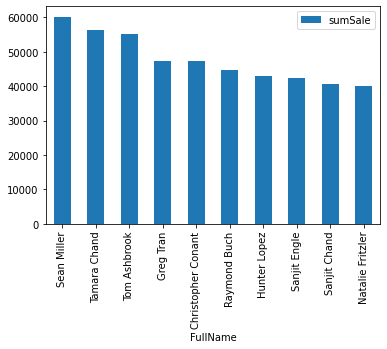

In [ ]:
sqlDF_p.plot.bar()

In [ ]:
sqlDF2 = spark.sql("SELECT Country, sum(Sales) as sumSale FROM custseg group by country order by sumSale desc  limit 10;")
sqlDF2.show()

+--------------+------------------+
|       Country|           sumSale|
+--------------+------------------+
| United States| 4544899.712599898|
|     Australia| 925235.8529999998|
|        France| 858931.0829999996|
|         China|        700562.025|
|       Germany|  628840.030500001|
|        Mexico| 622590.6175199975|
|         India| 589650.1049999992|
|United Kingdom| 528576.2999999993|
|     Indonesia| 404887.4978999994|
|        Brazil|361106.41896000056|
+--------------+------------------+



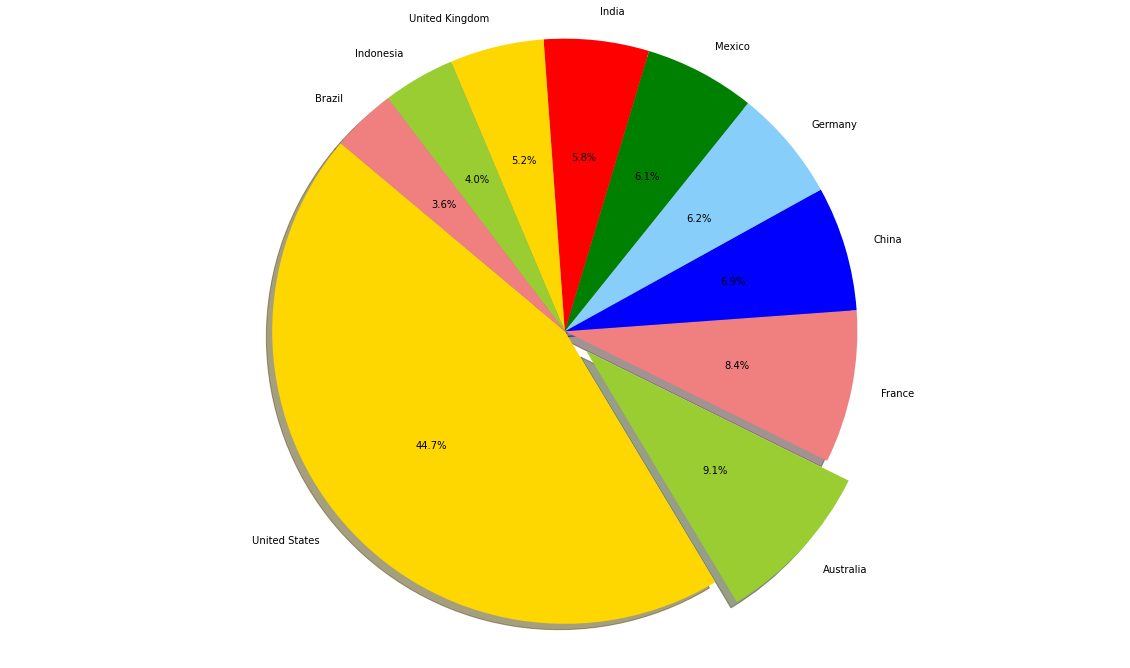

In [ ]:
import pandas as pd
sqlDF2_p = sqlDF2.toPandas()


import matplotlib.pyplot as plt
# Data to plot
labels = sqlDF2_p.Country
sizes =  sqlDF2_p.sumSale
colors = ['gold', 'yellowgreen', 'lightcoral','blue', 'lightskyblue','green','red']
explode = (0, 0.1, 0, 0,0,0,0,0,0,0)  # explode 1st slice

# Plot
plt.figure(figsize=(20,12))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()